# Programming assignment 3: spotting cars using convolutional neural network
### Camille Porter, Sarah Al-Khateeb, Katalin Ferenc

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

### 0. Import and pre-process the data

In [2]:
# rescale so that the color values range from 0 to 1 instead of 0 to 255
data_gen = ImageDataGenerator(rescale=1.0/255)

In [3]:
imgdir = 'pa3_images' 
img_size = 64 # resize the images to 64x64 
# (a more powerful computer can handle larger images and that performs better)
batch_size = 32  # batch size used for training
picture_number = 1600

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


The dimension of X: 
(32, 64, 64, 3)
The class of the first image: 
1.0


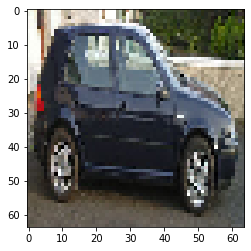

In [4]:
#take a look at a few images
Xbatch, Ybatch = train_generator.next()
print("The dimension of X: ")
print(Xbatch.shape)
print("The class of the first image: ")
print(Ybatch[4])
#Draw the image
plt.imshow(Xbatch[4]);

Xbatch, Ybatch = train_generator.next()
returns a four-dimensional NumPy array (formally, a four-dimensional tensor).
- 32, because there are 32 images in the batch
- 64, for the height of each image
- 64, for the width of each image
- 3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

### Part 1: Training a convolutional neural network 

In [5]:
def make_convnet(img_width, img_height, img_depth=3):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_width, img_height, img_depth)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [6]:
model = make_convnet(64, 64, 3)

In [7]:
H = model.fit_generator(train_generator,
                        validation_data=validation_generator, 
                        steps_per_epoch=picture_number//batch_size,
                        epochs=15)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 18 steps
Epoch 1/15
50/50 [==============================] - 14s 272ms/step - loss: 0.6532 - accuracy: 0.6144 - val_loss: 0.6008 - val_accuracy: 0.7014
Epoch 2/15
50/50 [==============================] - 11s 221ms/step - loss: 0.5043 - accuracy: 0.7625 - val_loss: 0.5262 - val_accuracy: 0.7622
Epoch 3/15
50/50 [==============================] - 11s 224ms/step - loss: 0.4657 - accuracy: 0.7837 - val_loss: 0.5496 - val_accuracy: 0.7344
Epoch 4/15
50/50 [==============================] - 12s 236ms/step - loss: 0.4307 - accuracy: 0.8081 - val_loss: 0.5182 - val_accuracy: 0.7569
Epoch 5/15
50/50 [==============================] - 12s 243ms/step - loss: 0.3888 - accuracy: 0.8331 - val_loss: 0.5353 - val_accuracy: 0.7535
Epoch 6/15
50/50 [==============================] - 11s 219ms/step - loss: 0.3013 - accuracy: 0.8813 - val_loss: 0.56

We tried to run using 100 epochs but after 15 epoch the accuracy is the same, so we kept the 15 epoch version

In [8]:
score = model.evaluate(validation_generator, verbose = 0)
print('Test loss: ' , score[0])
print('Tests accuracy: ', score[1])

  ...
    to  
  ['...']
Test loss:  1.214466071791119
Tests accuracy:  0.7743056


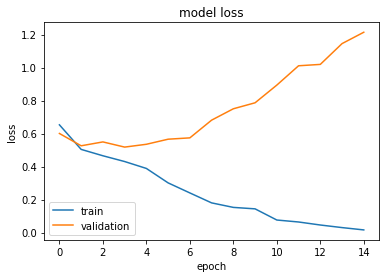

In [9]:
# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

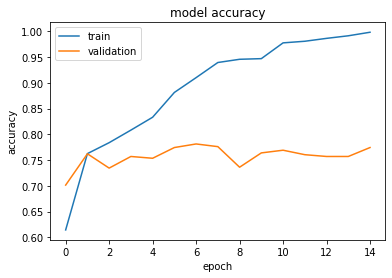

In [10]:
#  "Accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 We want to maximize the accuracy of the validation data and minimize the loss of the same data. As we see on the first plot, the validation loss stops decreasing after about the 1st epoch and slowly increasing again. On the second plot we see that the validation accuracy does not increase after about the 5th epoch (and increase only very slowly before that).
 
 So we conclude that our network overfits the data from about the 1st-2nd epoch. To mitigate overfitting, we could force early stopping or apply augmentation on our input data. We choose the latter one.

##### Side note

Accidentally we set the steps_per_epoch parameter to 800//32 and interestingly we saw less overfitting. Training accuracy did not reach 100% before 10 epochs and validation accuracy was not dropping before about the 6th epoch. We think it is because data_generator selects pictures randomly so in the 800//32 scenario we select half of the data randomly in each epoch, thus reduce overfitting. However, this also reduced the validation accuracy to 77% as we did not learn from all of our data.

### Part 2: Data augmentation 

*Most likely, unless you applied early stopping very aggressively, you saw some overfitting in your solution. One approach to reducing the risk of overfitting to the training set is to apply data augmentation. This means that we create additional training instances by applying different types of modifications to the existing training images. Make a new training data generator that uses different types of data augmentation, such as rotation, mirroring, and changing the colors to generate new training data.*

In [11]:
# create generator that modifies data real-time during fitting
train_aug = ImageDataGenerator(rescale=1./255, rotation_range=20, 
    brightness_range=[0.7,1.0], shear_range=0.2, zoom_range=0.2,
    channel_shift_range=0.5, horizontal_flip=True)

In [12]:
imgdir = 'pa3_images' # or wherever you put them...
img_size = 64
batch_size = 32

train_generator_aug = train_aug.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


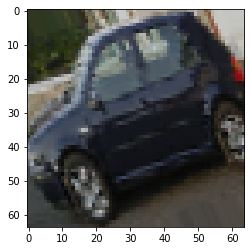

In [13]:
Xbatch, Ybatch = train_generator_aug.next()
plt.imshow(Xbatch[4]);

We can see the image has been distorted. For me it is a car that is rotated to left.

In [14]:
H_aug = model.fit_generator(train_generator_aug,
                            validation_data=validation_generator, 
                            steps_per_epoch=picture_number//batch_size,
                            epochs=15)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 18 steps
Epoch 1/15
50/50 [==============================] - 15s 296ms/step - loss: 0.4969 - accuracy: 0.8050 - val_loss: 0.5633 - val_accuracy: 0.7622
Epoch 2/15
50/50 [==============================] - 16s 314ms/step - loss: 0.3869 - accuracy: 0.8300 - val_loss: 0.5294 - val_accuracy: 0.7743
Epoch 3/15
50/50 [==============================] - 15s 309ms/step - loss: 0.3723 - accuracy: 0.8325 - val_loss: 0.4961 - val_accuracy: 0.7882
Epoch 4/15
50/50 [==============================] - 15s 308ms/step - loss: 0.3617 - accuracy: 0.8325 - val_loss: 0.4892 - val_accuracy: 0.7865
Epoch 5/15
50/50 [==============================] - 15s 299ms/step - loss: 0.3526 - accuracy: 0.8406 - val_loss: 0.5696 - val_accuracy: 0.7674
Epoch 6/15
50/50 [==============================] - 15s 303ms/step - loss: 0.3444 - accuracy: 0.8519 - val_loss: 0.5603 - val_accuracy: 0.7639
Epoch 7/15
50/50 [==============================] 

In [15]:
score = model.evaluate(validation_generator, verbose=0)
print('Test loss: ' , score[0])
print('Tests accuracy: ', score[1])

  ...
    to  
  ['...']
Test loss:  0.5899881782631079
Tests accuracy:  0.8020833


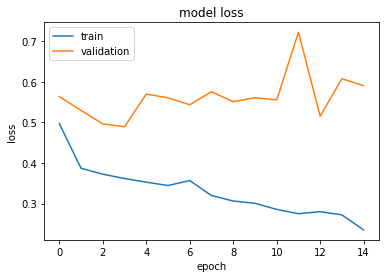

In [16]:
# "Loss"
plt.plot(H_aug.history['loss'])
plt.plot(H_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

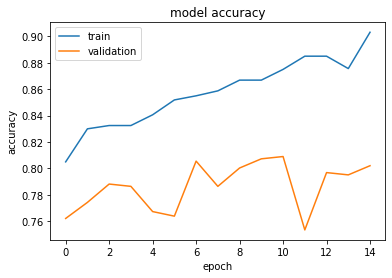

In [17]:
#  "Accuracy"
plt.plot(H_aug.history['accuracy'])
plt.plot(H_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Compared to the previous training, we see great improvement in terms of overfitting. The validation accuracy did not increase very much, but the loss decreased a lot. We see that there is not much improvement after about 10 epochs, so if we would do early stopping, that would be applied there.

### Optional task

We ran it on the server and it was indeed faster. An option might have been using input data of higher resolution, such as image size of 128x128 instead of 64x64, but we could not manage it in this setting.

### Interlude: Applying a pre-trained convolutional neural network


In [18]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

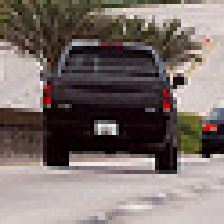

In [19]:
# Load the image
img = load_img('pa3_images/train/car/0000.jpg', target_size=(224,224))
# Convert the image into a 3-dimensional NumPy array
img_arr = img_to_array(img)
img

In [20]:
# Process the image using the Keras function preprocess_input
# This function returns a new NumPy array. This step carries out 
# some preprocessing of the image necessary for VGG-16
arr_proc = preprocess_input(img_arr)
# reshape the image array into a four-dimensional array
# The reason for reshaping is that the predict function 
# in Keras operates on "batches" of images. Even if we are
# classifying just a single image, we need to put it into an array
your_image = arr_proc.reshape(1,224,224,3)
#Predict the class probabilities for this image
#There are 1000 columns because the VGG-16 classifier uses 
# 1000 ImageNet classes
pred = vggmodel.predict(your_image)

In [21]:
# convert the probability matrix into human-readable 
# ImageNet class labels
decode_predictions(pred)

[[('n03417042', 'garbage_truck', 0.15934132),
  ('n03345487', 'fire_engine', 0.1115574),
  ('n04252225', 'snowplow', 0.100916825),
  ('n06874185', 'traffic_light', 0.08726455),
  ('n03977966', 'police_van', 0.086844794)]]

VGG-16 predictions look pretty accurate, which is pretty cool. It is not perfect of course, but the top5 prediction are very understandable.

### Part 3: Using VGG-16 as a feature extractor

*Since we just have 1,600 training images, the CNN we trained earlier wasn't fantastically successful. We'll now take a different approach, inspired by the paper by Razavian et al. (2014): we'll use the VGG-16 model as a feature extractor: we'll apply the convolutional part of the VGG-16 model to our images, and use this output as the input of our own classifier. This solution is an example of transfer learning, which means that we leverage the knowledge stored in a pre-trained model and apply it to our specific task.*

In [22]:
feature_extractor = applications.VGG16(weights='imagenet', 
                                       include_top=False,
                                       input_shape=(img_size, img_size, 3))

In [23]:
# create a new ImageDataGenerator that applies preprocess_input 
# (the preprocessing required for VGG-16) to the images that it processes

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
def create_vgg16_features(directory):
    tgen = vgg_data_gen.flow_from_directory(
        imgdir + "/" + directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)
    cnn_features = feature_extractor.predict(tgen)
    with open(directory+"features", 'wb') as f:
        np.save(f, cnn_features)

In [25]:
create_vgg16_features("train")
create_vgg16_features("validation")

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [26]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

In [27]:
def read_data(name):
    with open(name+"features",'rb') as f:
        the_data = np.load(f)
    return the_data

We were experimenting with different models, and found this one below giving the highest validation accuracy score.

In [28]:
def get_model(n_cols):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128,activation="relu",input_shape=(n_cols,)))
    # dropout is a technique where randomly selected neurons are 
    # ignored during training, thus reducing overfitting.
    model.add(Dropout(.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [38]:
def train_on_cnnfeatures():
    train_data = read_data("train")
    val_data = read_data("validation")
    train_label = get_labels(int(train_data.shape[0]))
    val_label = get_labels(int(val_data.shape[0]))
    model = get_model(int(train_data.shape[1]))
    tcnnm = model.fit(x=train_data,y=train_label,
                      validation_data=(val_data,val_label), 
                      steps_per_epoch=int(picture_number//batch_size),
                      epochs=20)
    return tcnnm

In [39]:
TCNm = train_on_cnnfeatures()

Train on 1600 samples, validate on 576 samples
Epoch 1/20
1600/1600 [==============================] - 1s 897us/sample - loss: 2.5633 - accuracy: 0.7425 - val_loss: 0.6235 - val_accuracy: 0.8698
Epoch 2/20
1600/1600 [==============================] - 1s 391us/sample - loss: 0.9709 - accuracy: 0.8331 - val_loss: 0.4099 - val_accuracy: 0.8924
Epoch 3/20
1600/1600 [==============================] - 1s 518us/sample - loss: 0.7073 - accuracy: 0.8575 - val_loss: 0.4665 - val_accuracy: 0.8889
Epoch 4/20
1600/1600 [==============================] - 1s 387us/sample - loss: 0.5672 - accuracy: 0.8800 - val_loss: 0.4392 - val_accuracy: 0.8819
Epoch 5/20
1600/1600 [==============================] - 1s 462us/sample - loss: 0.4018 - accuracy: 0.8938 - val_loss: 0.3945 - val_accuracy: 0.8872
Epoch 6/20
1600/1600 [==============================] - 1s 598us/sample - loss: 0.3253 - accuracy: 0.9087 - val_loss: 0.3584 - val_accuracy: 0.8993
Epoch 7/20
1600/1600 [==============================] - 1s 491us/

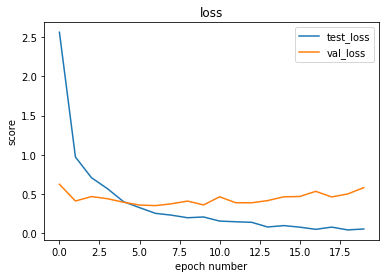

In [40]:
plt.plot(TCNm.history['loss'], label='test_loss')
plt.plot(TCNm.history['val_loss'], label='val_loss')
plt.title("loss")
plt.xlabel("epoch number")
plt.ylabel("score")
plt.legend()

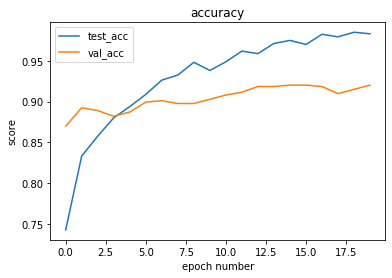

In [41]:
plt.plot(TCNm.history['accuracy'], label='test_acc')
plt.plot(TCNm.history['val_accuracy'], label='val_acc')
plt.title("accuracy")
plt.xlabel("epoch number")
plt.ylabel("score")
plt.legend()

The model is not overtrained as quickly using this method. We have higher accuracy and lower loss for the validation data as well. Interestingly, the validation accuracy was high from the beginning and increased only a bit after fine-tuning the model to our data. Epoch 15 was probably the best with a validation accuracy of 0.92 and loss equal to 0.46. This model also ran much faster.

### Part 4: Visualizing the learned features

*The first convolutional layer represents the most low-level patterns that the model looks for in images. We will now visualize these features in the VGG-16 model. We get the weights in this convolutional layer. This is a four-dimensional NumPy tensor: width x height x colors x number of convolutions.*

In [31]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

*We create a utility function that will help us visualize the patterns extracted by the first convolutional layer.*

*This function takes three inputs: the layer's weight tensor (from the step above), a number referring to which convolutional filter we are considering (0-63), and finally a boolean (True/False) value that says whether we want to see the positive or the negative part of this filter. (That is, if positive=True, we see the patterns which enable this "feature"; if it is False, we see the patterns that disable it.) Visualize some of the patterns used by the first convolutional layer. It can be useful to show these images in pairs, so that for each convolutional filter you see the positive and negative pattern.*

In [32]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

In [33]:
k1_pos = kernel_image(first_layer_weights, 3, positive=True)
k2_pos = kernel_image(first_layer_weights, 32, positive=True)
k1_neg = kernel_image(first_layer_weights, 3, positive=False)
k2_neg = kernel_image(first_layer_weights, 32, positive=False)

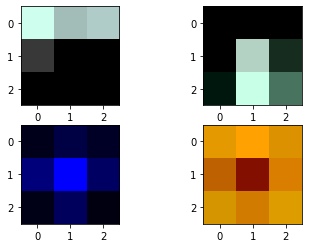

In [34]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(k1_pos)
axarr[0,1].imshow(k1_neg)
axarr[1,0].imshow(k2_pos)
axarr[1,1].imshow(k2_neg);

These images show the activation (left) and de-activation (right) patterns for two filters. It is interesting to see that complement colors or pattern and lack of patterns makes a filter turn on or off. It would be fun to see which pattern combination decides if a picture has a car on it, but that would require deeper knowledge and clever techniques to visualize.